# L’analyse du commerce électronique brésilien

#### Père castor raconte moi une histoire....

## Importations des librairies

In [29]:
import pandas as pd, numpy as np, os, warnings, seaborn as sns
from datetime import datetime as dt
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
font1 = fm.FontProperties(size=20)
font2 = fm.FontProperties(size=24)

# %matplotlib inline
%pylab inline

if int(str(sns.__version__).split('.')[1]) > 8 : 
    plt.style.use('seaborn-v0_8-darkgrid')
else:
    plt.style.use('seaborn-darkgrid')
    
sns.set(font_scale=2)
warnings.filterwarnings(action="ignore")

os.chdir("C:/Users/etien/Documents/CCI/_HUB/cours/2024-2025/big_data/_git/Python_pandas/donnees")

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


## Importations des doonées 

In [30]:
ventes = pd.read_parquet('ecommerce/analyse_ventes.parquet', engine='pyarrow')
ventes.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99441 entries, 0 to 99440
Data columns (total 68 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   order_id            99441 non-null  object        
 1   customer_id         99441 non-null  object        
 2   purchase_timestamp  99441 non-null  datetime64[us]
 3   approved_at         99281 non-null  datetime64[us]
 4   delivered_carrier   97658 non-null  datetime64[us]
 5   delivered_customer  96476 non-null  datetime64[us]
 6   estimated_delivery  99441 non-null  datetime64[us]
 7   status              99441 non-null  object        
 8   annee               99441 non-null  int32         
 9   mois                99441 non-null  int32         
 10  annee_mois          99441 non-null  int32         
 11  jour                99441 non-null  int32         
 12  annee_jour          99441 non-null  int32         
 13  jour_semaine        99441 non-null  int32     

### Concaténation de vente et produit

In [31]:
produits = pd.read_parquet('ecommerce/products.parquet', engine='pyarrow')
# produit.info()

In [32]:
achat = pd.read_parquet('ecommerce/analyse_achat.parquet', engine='pyarrow')
# achat.info()

In [ ]:
ventes_achat = ventes.merge(achat[['order_id', 'product_id']], on='order_id', how='left')
ventes_achat_produits = ventes_achat.merge(produits[['product_id', 'weight_g', 'length_cm', 'height_cm', 'width_cm']], 
                                         on='product_id', how='left')
#ventes_achat_produits.info()

### Nettoyage des valeurs extrem

In [50]:
ventes_achat_produits = ventes_achat_produits[(ventes_achat_produits['weight_g'] > 0) & (ventes_achat_produits['weight_g'] < ventes_achat_produits['weight_g'].quantile(0.99))]
ventes_achat_produits = ventes_achat_produits[(ventes_achat_produits['livree'] > 0) & (ventes_achat_produits['livree'] < ventes_achat_produits['livree'].quantile(0.99))]

### Concaténation de vente et moyen de payement

### 1/ "What is the average customer satisfaction score by state, quarter and payment method ?"

In [34]:
d1 = ventes.groupby(['name_state', 'trimestre', 'annee'])['score'].mean().reset_index()
d1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 216 entries, 0 to 215
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   name_state  216 non-null    object 
 1   trimestre   216 non-null    int32  
 2   annee       216 non-null    int32  
 3   score       216 non-null    float64
dtypes: float64(1), int32(2), object(1)
memory usage: 5.2+ KB


### 2/How do delivery times vary across different geographic and temporal levels ?  

Quelles dimensions a un impact sur le temps de livraison 

In [51]:
deliveryTime_by_period = ventes.groupby(['state', 'city', 'annee_trimestre'])['livree'].mean().reset_index()
deliveryTime_by_period

,state,city,annee_trimestre,livree
0,AC,brasileia,20171,0.900000
1,AC,cruzeiro do sul,20174,2.297639
2,AC,cruzeiro do sul,20182,23.540556
3,AC,epitaciolandia,20174,10.963889
4,AC,manoel urbano,20173,11.257222
...,...,...,...,...
13524,TO,tocantinopolis,20174,3.322083
13525,TO,tocantinopolis,20181,4.264167
13526,TO,tocantinopolis,20182,10.511111
13527,TO,xambioa,20174,3.153056


In [52]:
periode = ventes['annee_trimestre'].head(6)
periode


0    20174
1    20183
2    20183
3    20174
4    20181
5    20173
Name: annee_trimestre, dtype: int32

### 1 - Distribution des temps de livraison par état

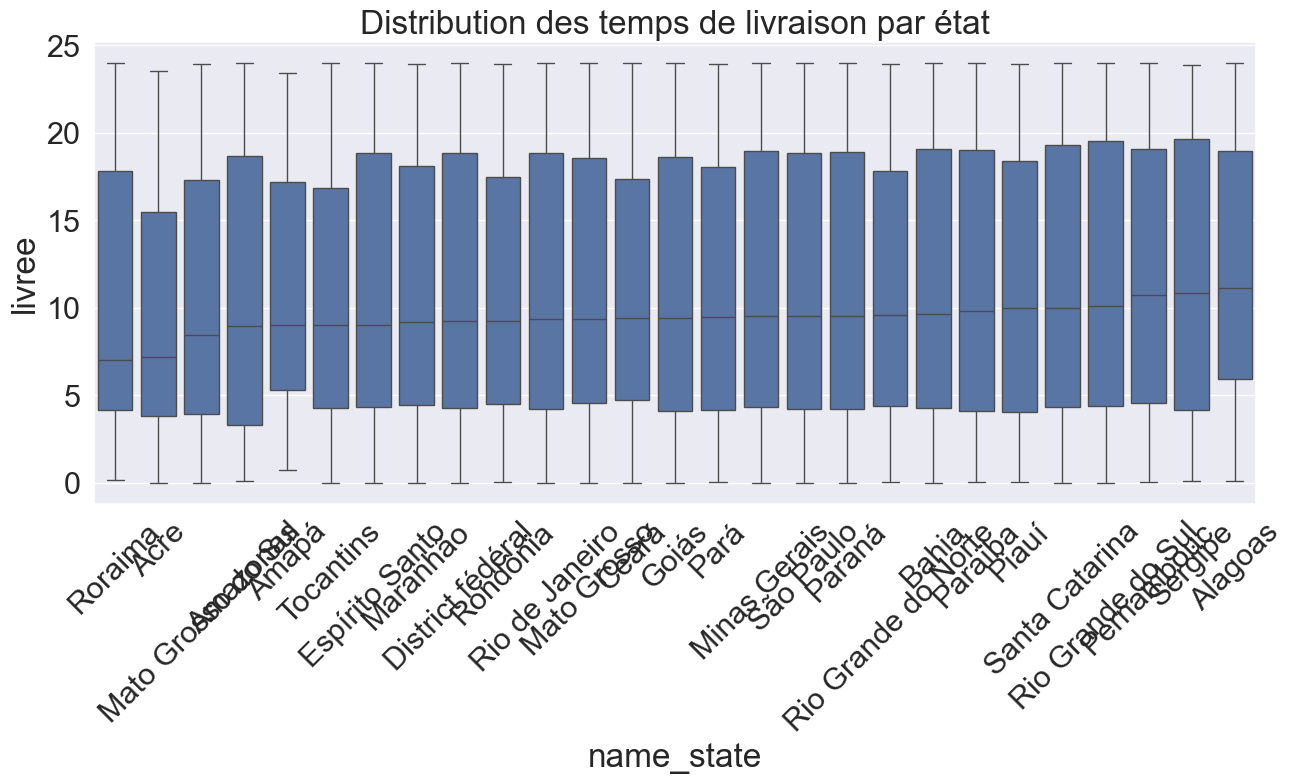

In [37]:
plt.figure(figsize=(15, 6))
sns.boxplot(data=ventes, x='name_state', y='livree', order=ventes.groupby('name_state')['livree'].median().sort_values().index)
plt.xticks(rotation=45)
plt.title('Distribution des temps de livraison par état')
plt.show()

In [38]:
TO_deliveryTime_by_period = deliveryTime_by_period[deliveryTime_by_period['state'] == 'TO']
mask = ventes['annee_trimestre'].isin(periode) 
TO_deliveryTime_by_period = TO_deliveryTime_by_period[mask]
TO_deliveryTime_by_period.head(200)


,state,city,annee_trimestre,livree
13409,TO,alianca do tocantins,20181,23.877778
13410,TO,alianca do tocantins,20182,23.972222
13411,TO,almas,20172,21.915556
13413,TO,alvorada,20173,11.885833
13415,TO,alvorada,20181,6.613750
...,...,...,...,...
13524,TO,tocantinopolis,20174,3.322083
13525,TO,tocantinopolis,20181,4.264167
13526,TO,tocantinopolis,20182,10.511111
13527,TO,xambioa,20174,3.153056


### 2 - Densité des temps de livraison pas période

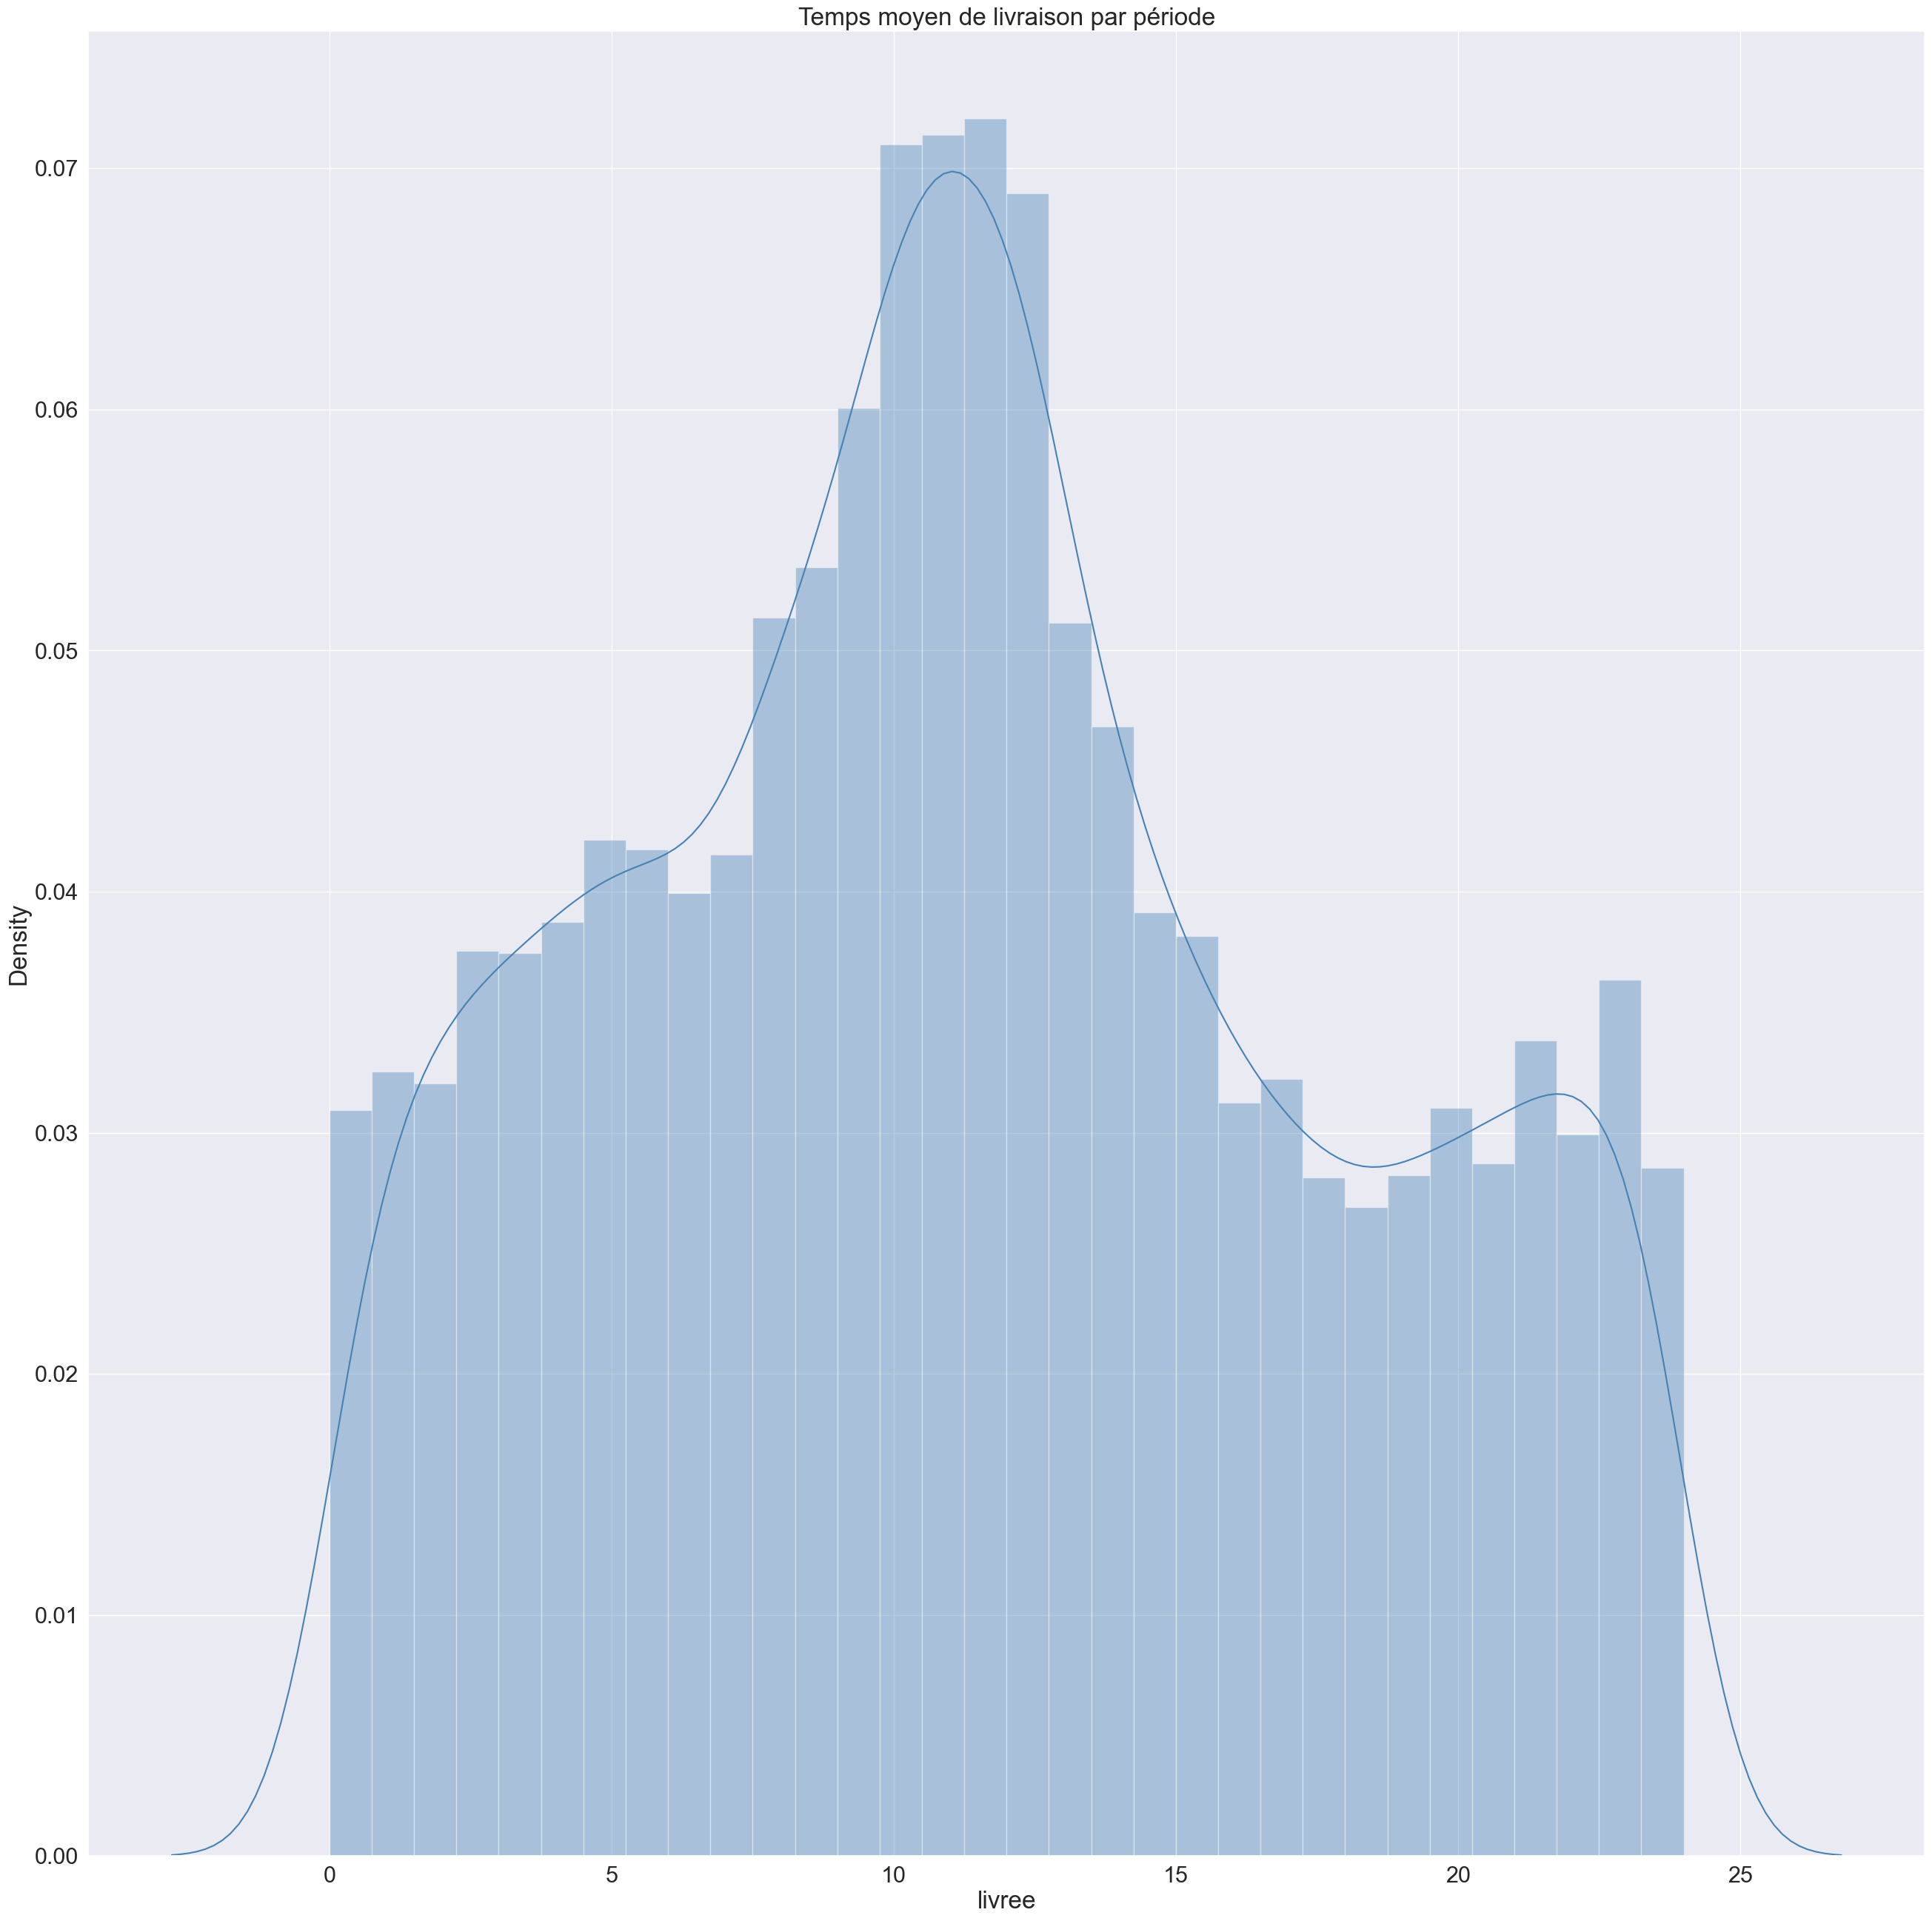

In [39]:
plt.figure(figsize=(32,32))
plt.title('Temps moyen de livraison par période', fontproperties=font2)
sns.distplot(deliveryTime_by_period['livree'], color="steelblue")
plt.show()

 interquartile range => là où se site 

### 3 - représentaion de la distribution des temps de livraison par état

RR  :  9.886470189701896
AC  :  9.55711111111111


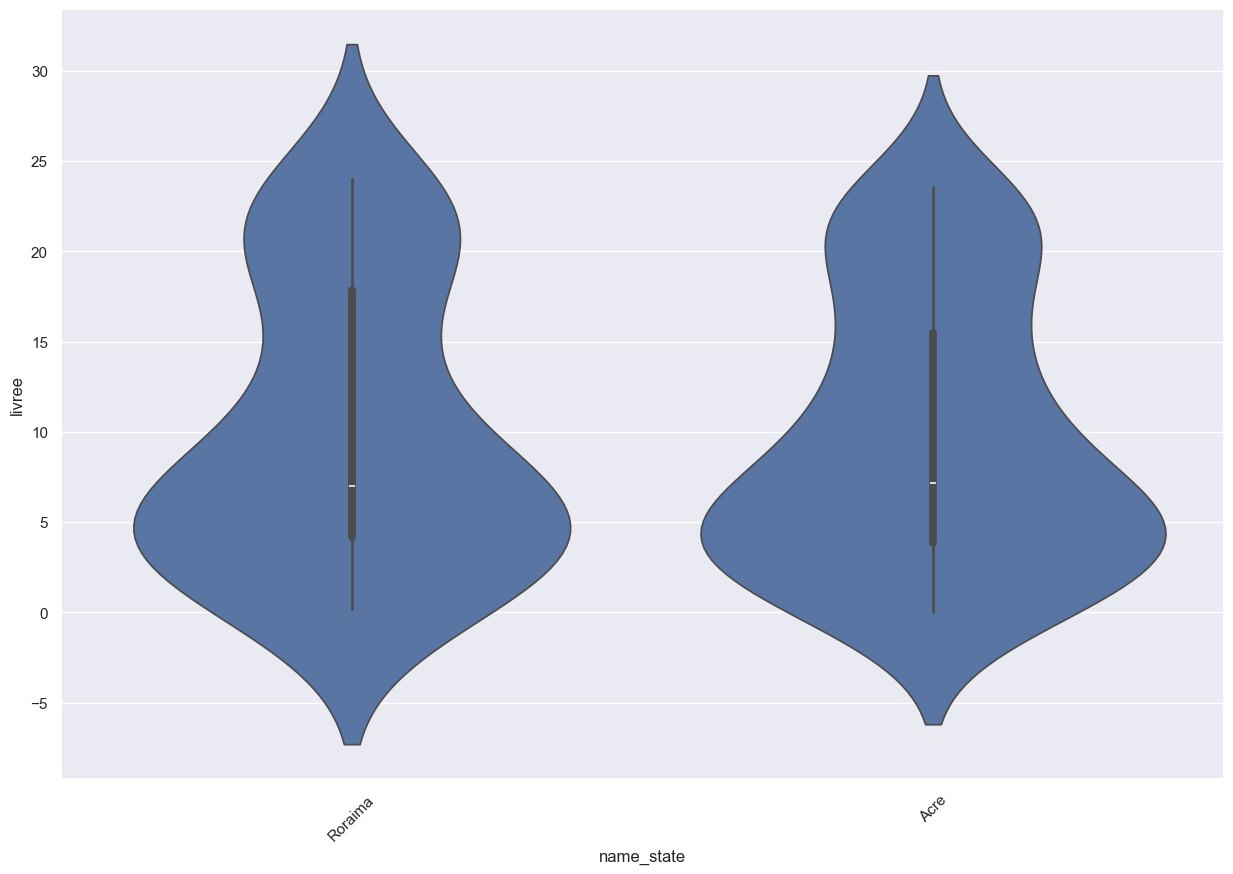

In [54]:
# https://mode.com/blog/violin-plot-examples


sns.set_theme(rc={'figure.figsize':(15, 10)})

country = ventes['state'].unique()

def getCountry_by_meanDelivery(country, nMean = 10):
    result = pd.DataFrame()
    for i in range(len(country)):
        countryName = country[i]
        currentCountryData = ventes[ventes['state'] == countryName] 
        if(currentCountryData["livree"].mean() < nMean):
            print(countryName, " : ", currentCountryData["livree"].mean())
            result = pd.concat([result, currentCountryData], ignore_index = True)
    return result

data = getCountry_by_meanDelivery(country, 10)

#print(data.info())

sns.violinplot(data = data, x = 'name_state', y = 'livree', width=0.8)
plt.xticks(rotation=45)
plt.show()

### 4 - Carte des temps de livraison moyen

ajouter un colonne temps de livraison moyen par état

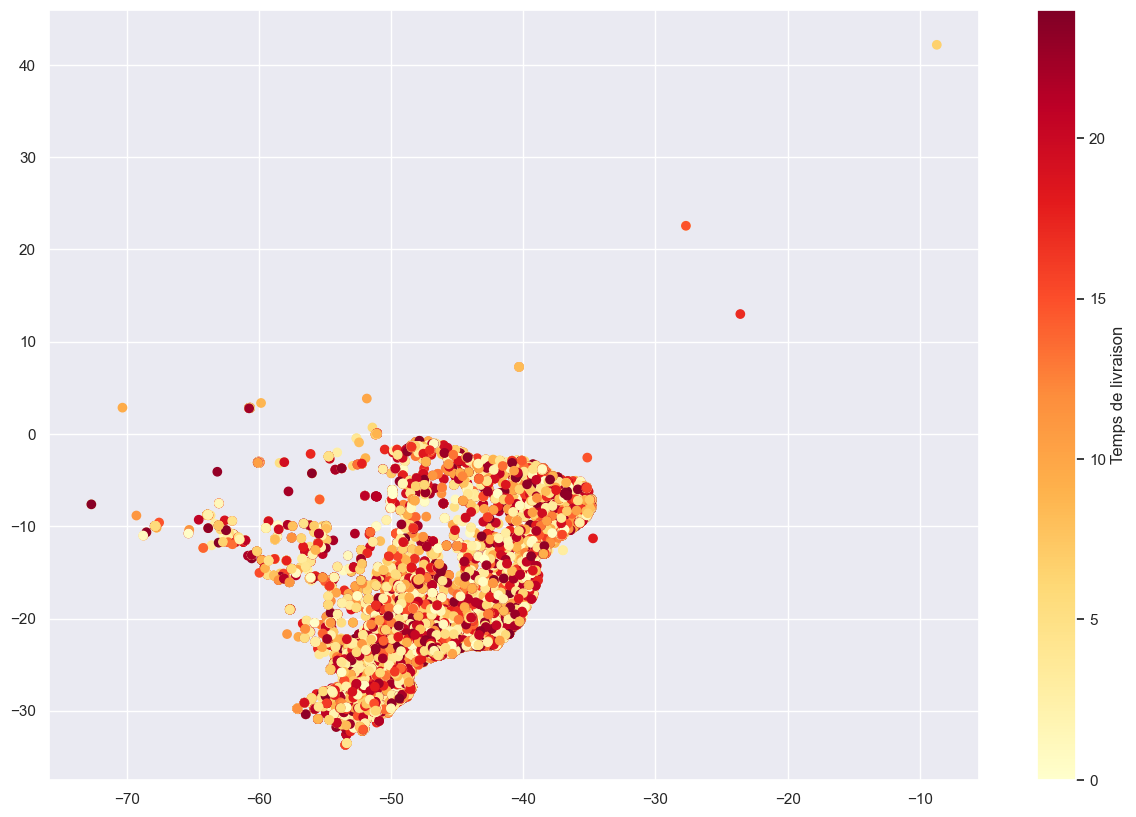

In [41]:
plt.scatter(ventes['lng'], ventes['lat'], c=ventes['livree'], cmap='YlOrRd')
plt.colorbar(label='Temps de livraison')
plt.show()

### 5 - Temps de livraison moyen par trimestre et par ville 

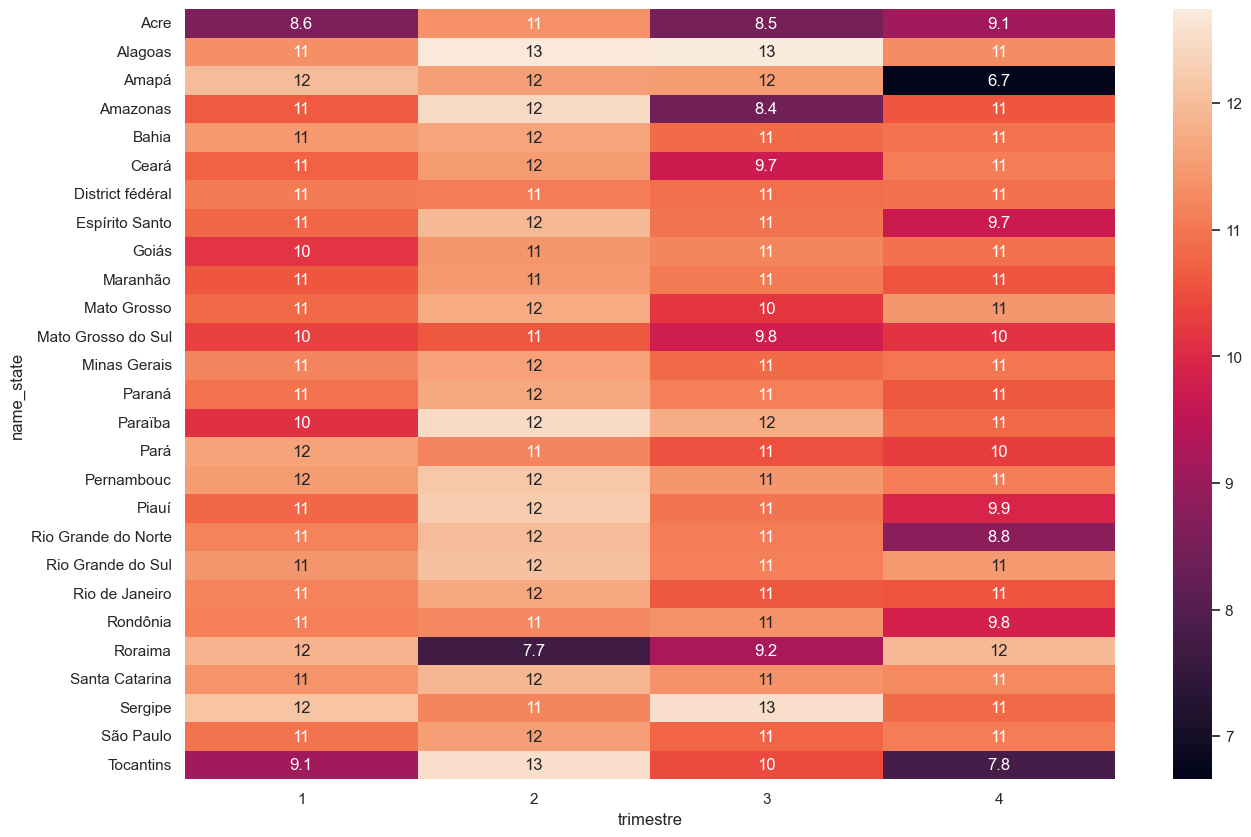

In [42]:
delivery_heatmap = ventes.pivot_table(
    values='livree',
    index='name_state',
    columns='trimestre',
    aggfunc='mean'
)
sns.heatmap(delivery_heatmap, annot=True)
plt.show()

### 6 - Comparaison des temps de livraison de tout les Etat

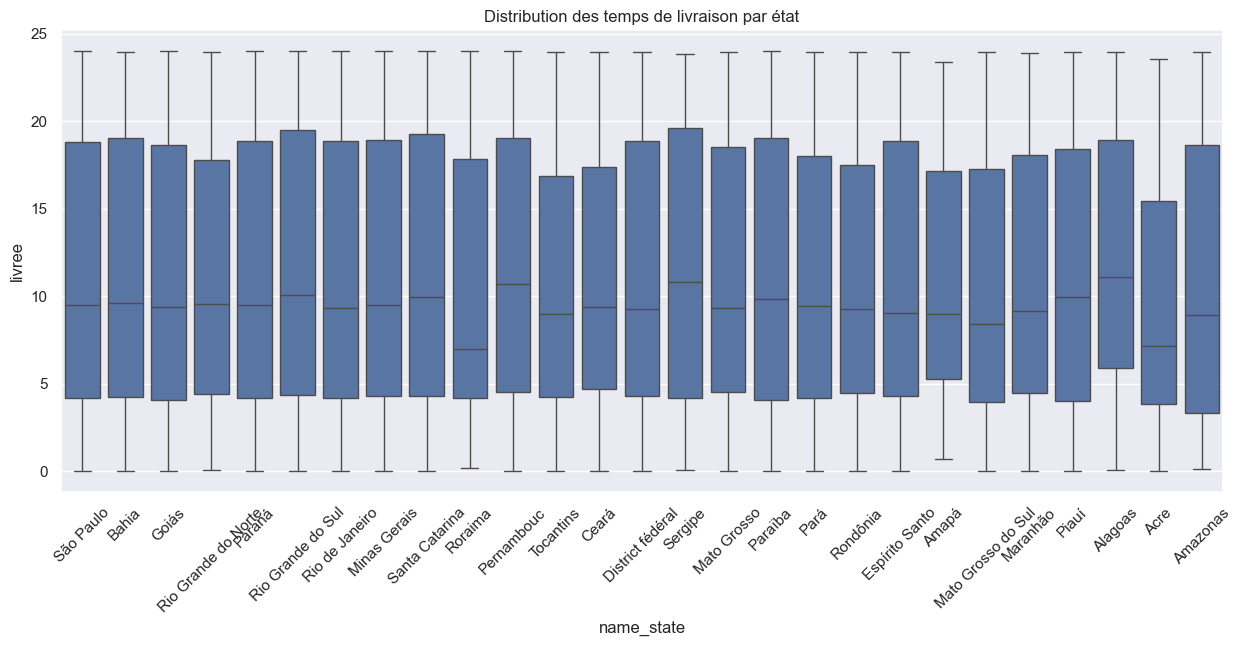

In [43]:
plt.figure(figsize=(15, 6))
sns.boxplot(data=ventes, x='name_state', y='livree')
plt.xticks(rotation=45)
plt.title('Distribution des temps de livraison par état')
plt.show()

### 7 - Evolution du temps de livraison par rapport au temps estimé en fonction du trimestre pour une région

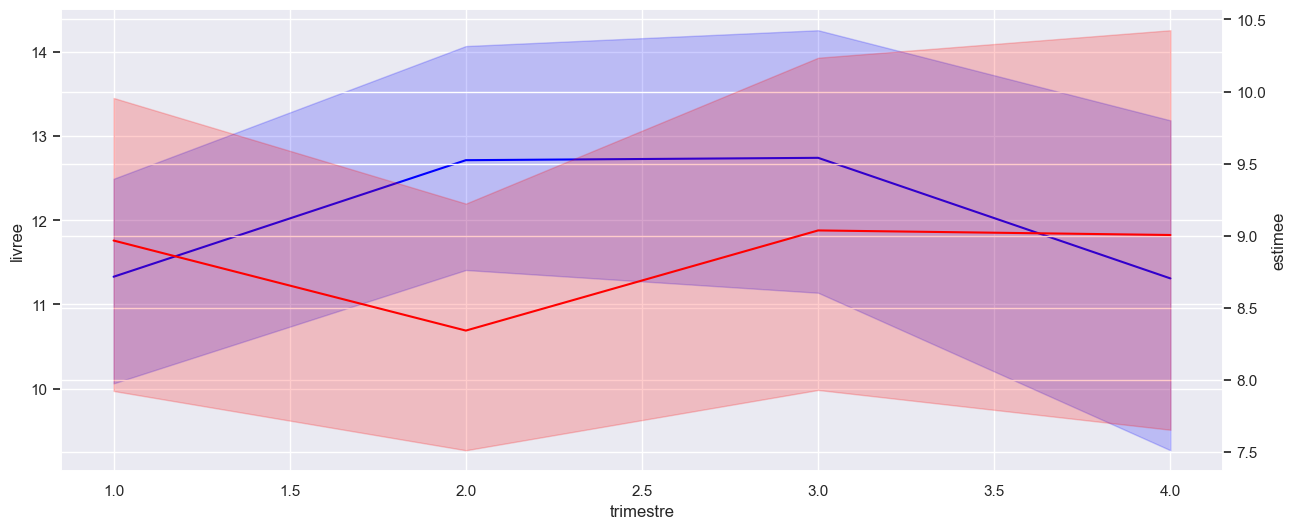

In [55]:
TO = ventes[ventes['state'] == 'AL']

fig, ax1 = plt.subplots(figsize=(15,6))
ax2 = ax1.twinx()
sns.lineplot(data=TO, x='trimestre', y='livree', ax=ax1, color='blue')
sns.lineplot(data=TO, x='trimestre', y='estimee', ax=ax2, color='red')
plt.show()

RR  :  9.886470189701896
AC  :  9.55711111111111


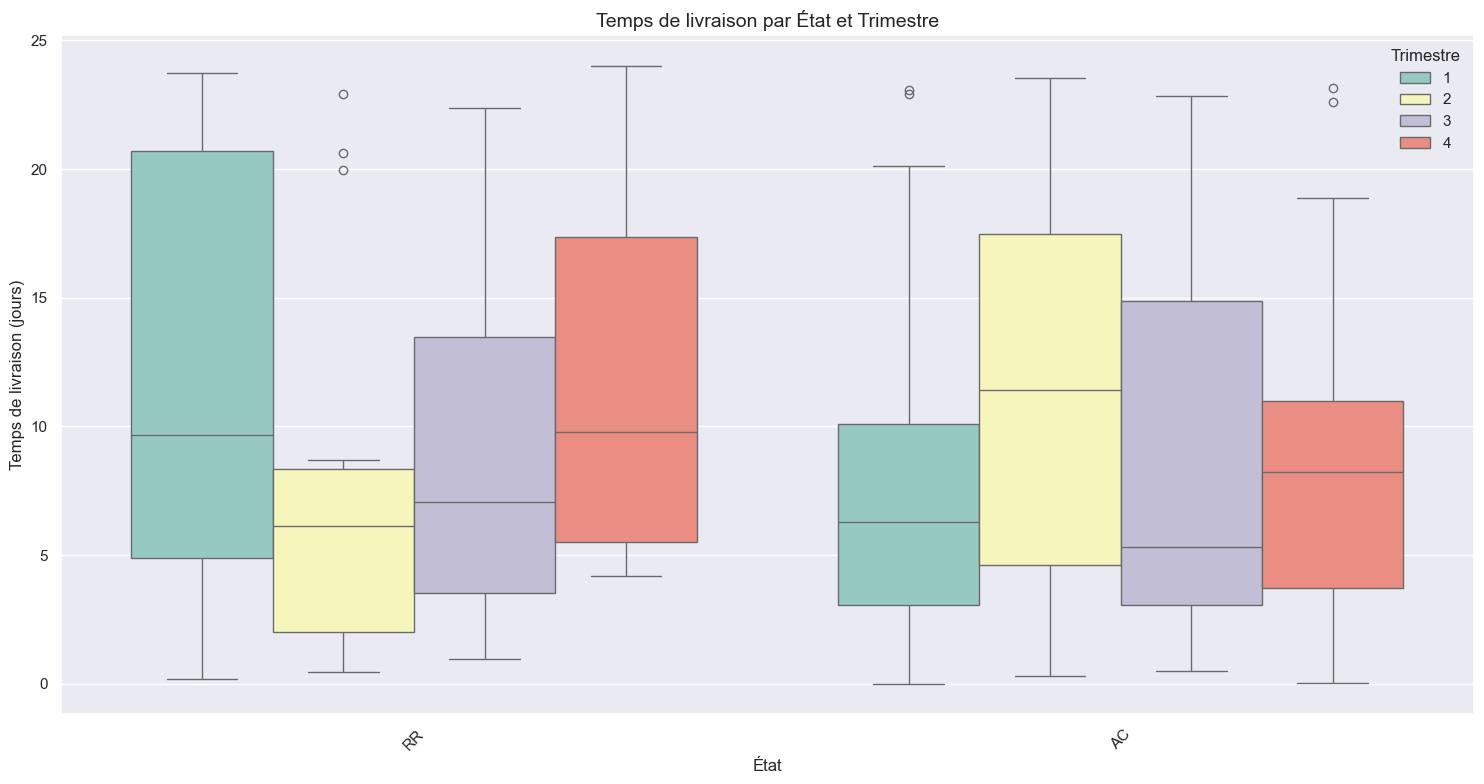

In [56]:

data = getCountry_by_meanDelivery(country, 10)

plt.figure(figsize=(15, 8))

sns.boxplot(data=data, 
            x='state',
            y='livree',
            hue='trimestre',
            palette='Set3')

plt.title('Temps de livraison par État et Trimestre', fontsize=14)
plt.xlabel('État', fontsize=12)
plt.ylabel('Temps de livraison (jours)', fontsize=12)
plt.xticks(rotation=45)

plt.legend(title='Trimestre')


plt.tight_layout()

plt.show()

#### 8 - Temps de livraison selon le poids du produit

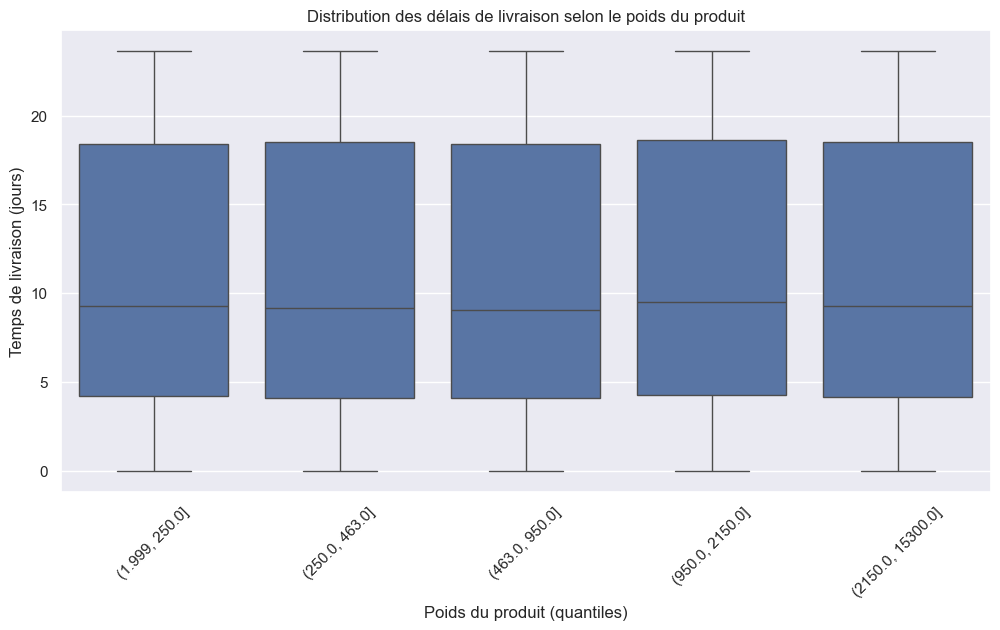

In [57]:
plt.figure(figsize=(12,6))
sns.boxplot(x=pd.qcut(ventes_achat_produits['weight_g'], q=5), y=ventes_achat_produits['livree'])
plt.xticks(rotation=45)
plt.xlabel("Poids du produit (quantiles)")
plt.ylabel("Temps de livraison (jours)")
plt.title("Distribution des délais de livraison selon le poids du produit")
plt.show()

#### 9 - Relation Poids/Taille vs Temps de livraison

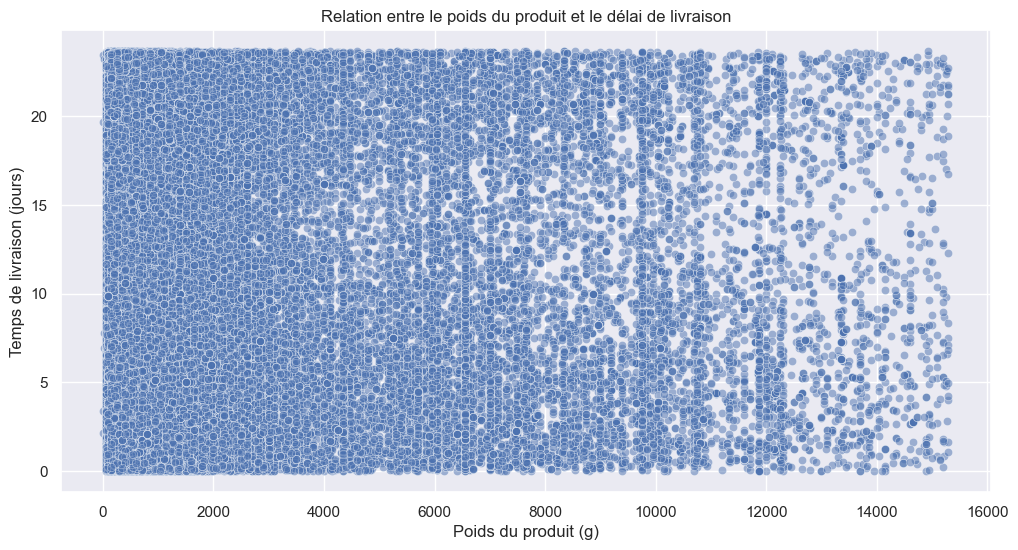

In [58]:
plt.figure(figsize=(12,6))
sns.scatterplot(data=ventes_achat_produits, x=ventes_achat_produits['weight_g'], y=ventes_achat_produits['livree'], alpha=0.5)
plt.xlabel("Poids du produit (g)")
plt.ylabel("Temps de livraison (jours)")
plt.title("Relation entre le poids du produit et le délai de livraison")
plt.show()

#### 10 - Retards en fonction des dimensions du produit 

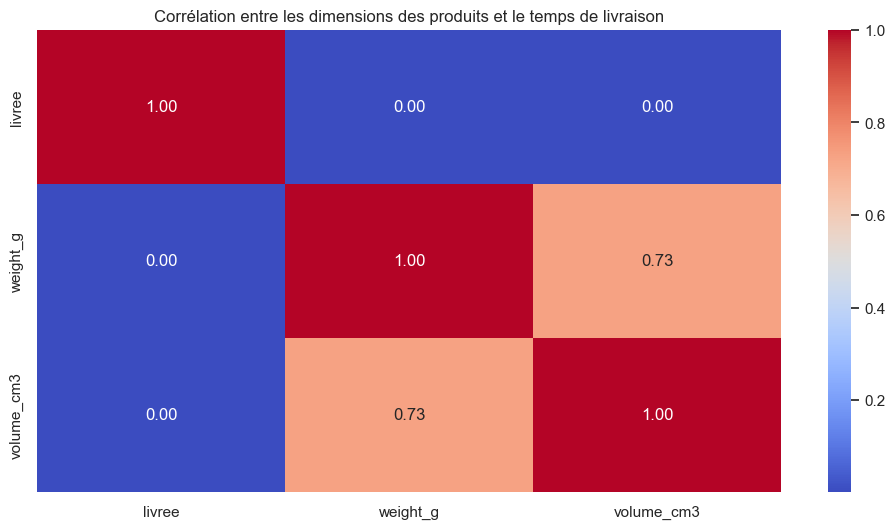

In [59]:
ventes_achat_produits['volume_cm3'] = ventes_achat_produits['length_cm'] * ventes_achat_produits['height_cm'] * ventes_achat_produits['width_cm']

plt.figure(figsize=(12,6))
corr_matrix = ventes_achat_produits[['livree', 'weight_g', 'volume_cm3']].corr()
sns.heatmap(corr_matrix, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Corrélation entre les dimensions des produits et le temps de livraison")
plt.show()

Il n'y a aucun rapport en le poids ou le volume et le délais de livraison. 

### 3/ "What is the payment method distribution by year, state and customer satisfaction level?"

In [46]:
d3 = ventes.groupby(['annee', 'name_state', 'score'])[['value_credit_card', 'value_debit_card', 'value_boleto']].sum()
d3.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 117 entries, (2016, 'Alagoas', 1) to (2018, 'Tocantins', 1)
Data columns (total 3 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   value_credit_card  117 non-null    float64
 1   value_debit_card   117 non-null    float64
 2   value_boleto       117 non-null    float64
dtypes: float64(3)
memory usage: 3.5+ KB


In [47]:
achat = pd.read_parquet('ecommerce/analyse_achat.parquet', engine='pyarrow')
achat.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 112650 entries, 0 to 112649
Data columns (total 51 columns):
 #   Column              Non-Null Count   Dtype         
---  ------              --------------   -----         
 0   order_id            112650 non-null  object        
 1   order_item_id       112650 non-null  int64         
 2   product_id          112650 non-null  object        
 3   seller_id           112650 non-null  object        
 4   price               112650 non-null  float64       
 5   freight_value       112650 non-null  float64       
 6   shipping_limit      112650 non-null  datetime64[us]
 7   limit               112650 non-null  float64       
 8   name_lenght         111047 non-null  float64       
 9   description_lenght  111047 non-null  float64       
 10  photos_qty          111047 non-null  float64       
 11  weight_g            112632 non-null  float64       
 12  length_cm           112632 non-null  float64       
 13  height_cm           112632 no